In [5]:
import emcee
import numpy as np
import corner
from multiprocessing import Pool
from bces import bces
import sys, os
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../modules/'))
from modules.settings import global_mmf_settings as gset
from wrapper_scripts import evaluate_Y_M_scaling_reln_cosmo_cat as ymsr
from modules.settings import global_mmf_settings as gset
from fitstat import fit_Y_M_scaling_law_emcee as fitYM
from fitstat import fit_Y_M_scaling_law_bces as fitYMbces
from cosmology import cosmo_fn

%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [6]:
dataset="planck_pr1"
whichch="hfi"
mask_point_sources=False
numprocs=35

if whichch=="allch":
    chmin=30.
elif whichch=="hfi":
    chmin=100.

use_psf_data=True
ps_suffix="_inpainted_data"
if mask_point_sources:
    use_psf_data=False
    ps_suffix="_masked_data"
    
    
figstamp=dataset + "_" + whichch + ps_suffix
dir_suffix=whichch + ps_suffix

save_results=False
run_analysis=False

figstamp,dir_suffix

('planck_pr1_hfi_inpainted_data', 'hfi_inpainted_data')

In [7]:
outpath="/results/" + dataset + "/planck_cosmo_cat_" + dir_suffix + "/"
tempdatapath="/tempdata/" + dataset + "/planck_cosmo_cat/"
gset.setup_mmf_config(dataset=dataset,outpath=outpath,tempdatapath=tempdatapath,chmin=chmin,xsize=10.,do_band_pass=True,use_psf_data=use_psf_data)
figpath=gset.mmfset.paths["result_figs"]
pmmf=ymsr.Y_M_scaling() ; xsz_cat=pmmf.xsz_cat

ysz_cat=ymsr.ppd.get_cosmo_catalogue_ysz()
xsz_cat["BIAS"]=np.copy(ysz_cat["BIAS"])
xsz_cat["T500"]=np.copy(xsz_cat["TX"])
xsz_cat["M500"]=np.copy(ysz_cat["M_Yx_500"]/1e14)
xsz_cat["M500_err"]=(ysz_cat['ERRM_M_Yx_500'] + ysz_cat['ERRP_M_Yx_500'])*0.5/1e14
xsz_cat["YSZ_500"]=np.copy(ysz_cat['Y_500'])
xsz_cat["YSZ_500_err"]=np.copy(ysz_cat["ERR_Y_500"])

In [8]:
fxsz_cat={}
if run_analysis:
    start=time.time()
    pmmf.emask[:,:]=ymsr.gm.return_edge_apodized_mask(15.,20.)
    result=parallel_eval_Y500_blind(numprocs)
    print time.time()-start

    filename="ysz_cat_blind_apo_edge_mask.fits"
    fxsz_cat["b"]=ymsr.write_catalogue(result,filename=filename)
else:
    filename="ysz_cat_blind_apo_edge_mask.fits"
    fxsz_cat["b"]=ymsr.read_catalogue(filename=filename)
    
if run_analysis:
    start=time.time()
    pmmf.emask[:,:]=1.
    result=parallel_eval_Y500_blind(numprocs)
    print time.time()-start

    filename="ysz_cat_blind_no_edge_mask.fits"
    fxsz_cat["bnm"]=ymsr.write_catalogue(result,filename=filename)
else:
    filename="ysz_cat_blind_no_edge_mask.fits"
    fxsz_cat["bnm"]=ymsr.read_catalogue(filename=filename)
    
    
if run_analysis:
    pmmf.emask[:,:]=1.
    start=time.time()
    result=parallel_eval_Y500_xray_prior(numprocs)
    print time.time()-start

    filename="ysz_cat_xrayprior_no_edge_mask.fits"
    fxsz_cat["xnm"]=ymsr.write_catalogue(result,filename=filename)
else:
    filename="ysz_cat_xrayprior_no_edge_mask.fits"
    fxsz_cat["xnm"]=ymsr.read_catalogue(filename=filename)

if run_analysis:
    pmmf.emask[:,:]=ymsr.gm.return_edge_apodized_mask(15.,20.)
    start=time.time()
    result=parallel_eval_Y500_xray_prior(numprocs)
    print time.time()-start

    filename="ysz_cat_xrayprior_apo_edge_mask.fits"
    fxsz_cat["x"]=ymsr.write_catalogue(result,filename=filename)
else:
    filename="ysz_cat_xrayprior_apo_edge_mask.fits"
    fxsz_cat["x"]=ymsr.read_catalogue(filename=filename)

In [10]:
rese=fitYM.return_Y_M_fit(xsz_cat["YSZ_500"],xsz_cat["YSZ_500_err"],xsz_cat["M500"],xsz_cat["M500_err"],xsz_cat["z"],mbias=[],min_type="ORTH",nwalkers=50,nsamples=2000,ana_corr=True)

In [7]:
resb=fitYMbces.return_Y_M_fit(xsz_cat["YSZ_500"],xsz_cat["YSZ_500_err"],xsz_cat["M500"],xsz_cat["M500_err"],xsz_cat["z"],mbias=[],qcut=6.,fidx=0)

<IPython.core.display.Javascript object>


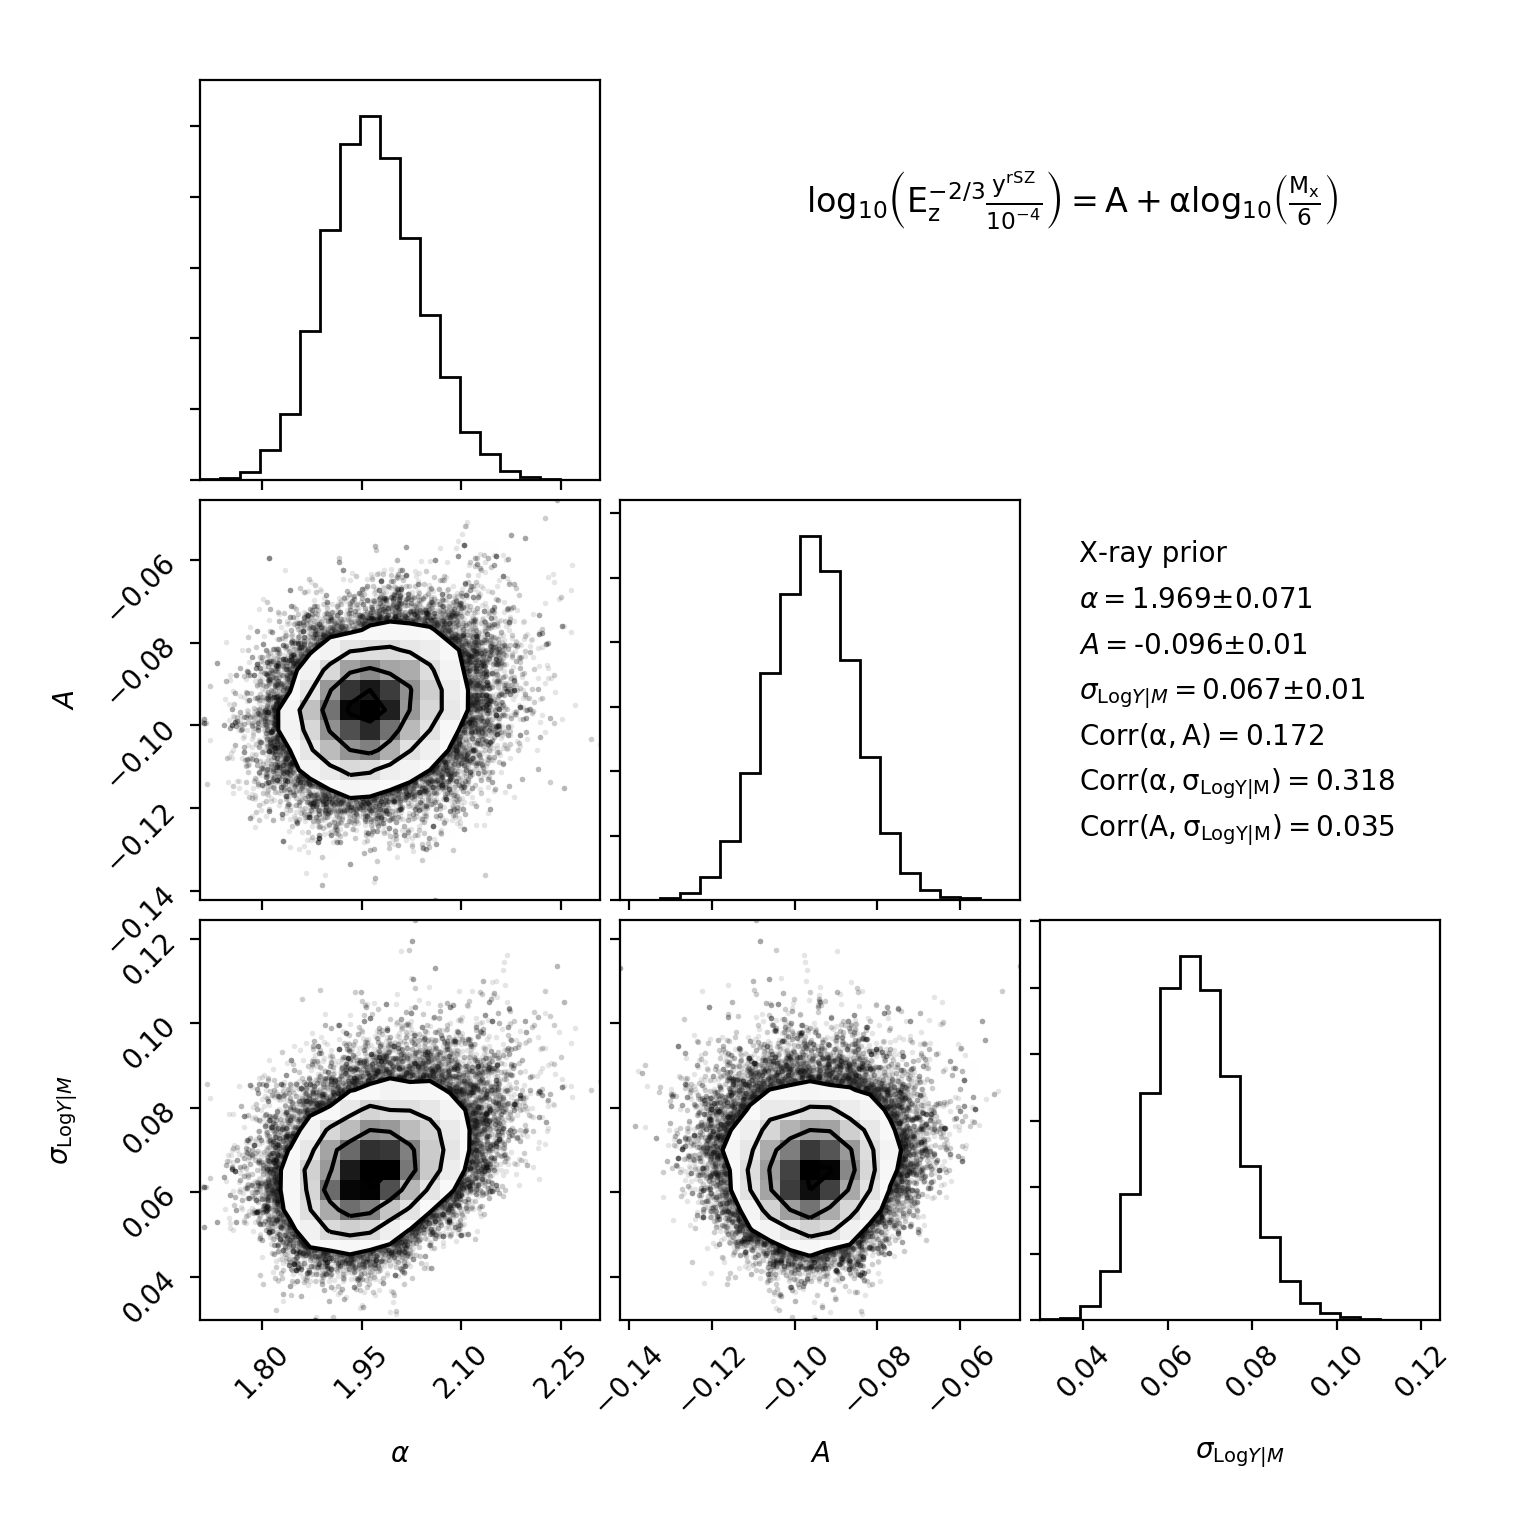

In [11]:
fitYM.gen_corner_plot(rese["samples"],figttl="X-ray prior")

<IPython.core.display.Javascript object>


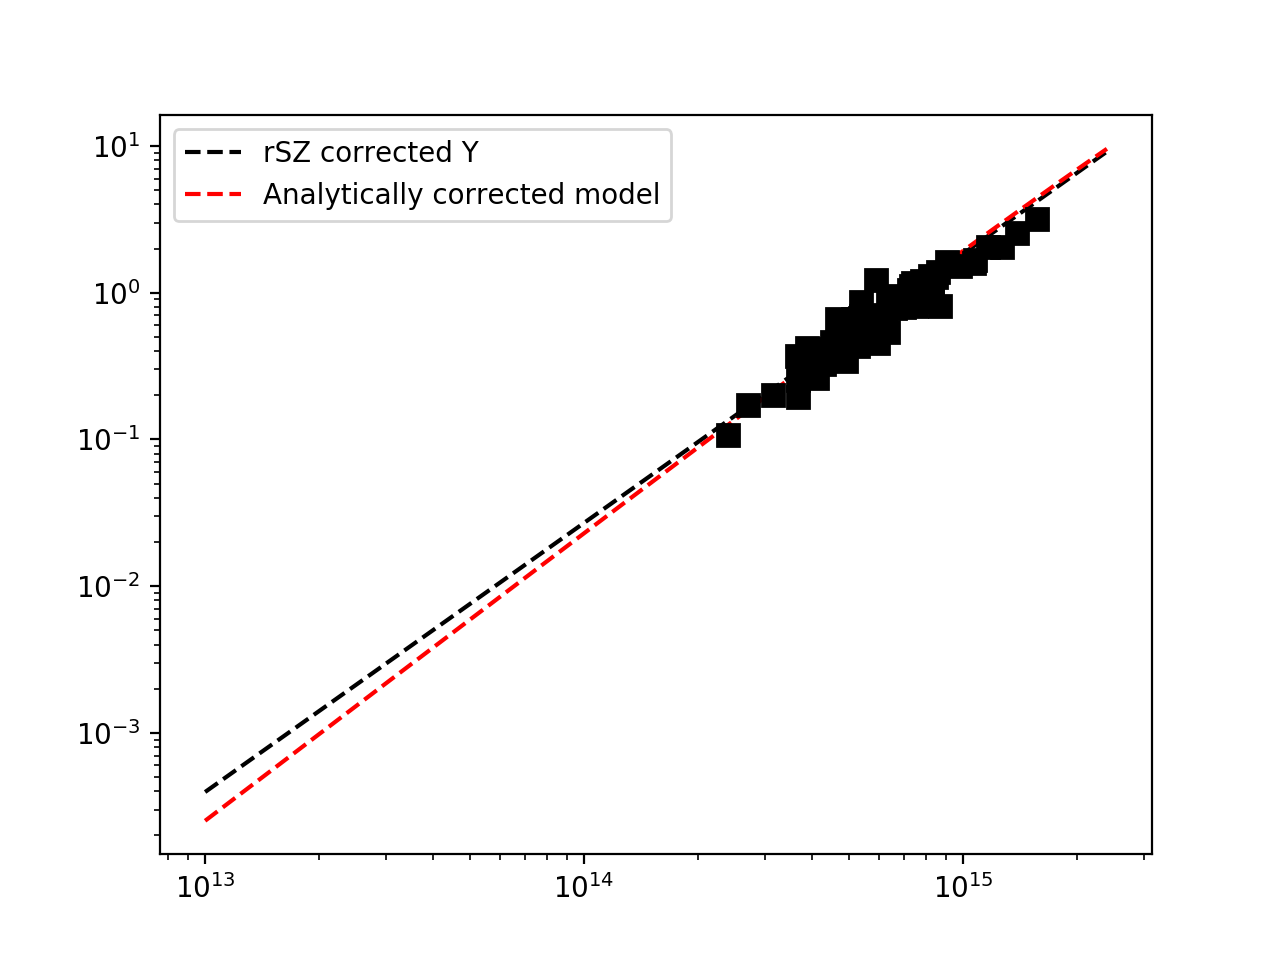

In [15]:
numdec=3
M500=linspace(0.1,24,1000)
Tx=cosmo_fn.convert_M500_T500(M500,0.)
norm=1e-4
figure()
Ezgamma=(cosmo_fn.Ez(xsz_cat["z"])**(-2./3.))/1e-4
errorbar(xsz_cat["M500"]*1e14,Ezgamma*xsz_cat["YSZ_500"],yerr=xsz_cat["YSZ_500_err"]*Ezgamma,fmt="s",c="k",markersize=8)
plot(M500*1e14,(10.**(-0.142))*((M500/6.)**1.834),"k--",label="rSZ corrected Y")
alpha=rese["param"][0] ; A=rese["param"][1]
plot(M500*1e14,(10.**A)*((M500/6.)**alpha)*(1-0.07*Tx/5.),"r--",label="Analytically corrected model")
#plot(M500*1e14,(10.**b[3])*((M500/6.)**a[3])*norm,"r-",label="BCES")
loglog()
legend(loc=0)

In [15]:
Ezgamma=(cosmo_fn.Ez(xsz_cat["z"])**(-2./3.))/1e-4
Ezgamma=Ezgamma #/xsz_cat["BIAS"]
TMx=cosmo_fn.convert_M500_T500(xsz_cat["M500"],xsz_cat["z"])
np.random.seed(0)
xdata=log10(xsz_cat["M500"]/6.) #+ log10((1.-0.07*xsz_cat["T500"]/5.)/((cosmo_fn.Ez(xsz_cat["z"])**(-2./3.))/1e-4))
xerr=ymsr.return_log_err(xsz_cat["M500"]/6.,xsz_cat["M500_err"]/6.)

# Catalogue
ydata=log10(xsz_cat["YSZ_500"]*Ezgamma)
yerr=ymsr.return_log_err(xsz_cat["YSZ_500"]*Ezgamma,xsz_cat["YSZ_500_err"]*Ezgamma)

# Blind
# ydata=log10(fxsz_cat["xnm"]["YSZ_500"]*Ezgamma)
# yerr=ymsr.return_log_err(fxsz_cat["xnm"]["YSZ_500"]*Ezgamma,fxsz_cat["xnm"]["YSZ_500_err"]*Ezgamma)

In [16]:
def lnlike(param, x, y, xerr,yerr):
    m, b, log10int_scat = param
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + m**2*xerr**2. + 10.**(2.*log10int_scat))
    dmm=(y-model)
    #inv_sigma2 = 1.0/((yerr**2 + m**2*xerr**2.)/(1. + m**2.) + 10.**(2.*log10int_scat)*np.cos(np.arctan(m))**2.)
    #dmm=(y-model)/np.sqrt(1. + m**2.)
    return -0.5*(np.sum(dmm**2.*inv_sigma2 - np.log(inv_sigma2)))


# def lnlike(param, x, y, xerr,yerr):
#     m, b, log10int_scat = param
#     model = m * x + b
#     #inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
#     inv_sigma2 = 1.0/((yerr**2 + (m*xerr)**2.) + 10.**(2.*log10int_scat))
#     dmm=(y-model)
#     return -0.5*(np.sum(dmm**2.*inv_sigma2 - np.log(inv_sigma2)))

def lnprior(param):
    m, b, log10int_scat = param
    if 0. < m < 4. and -2.0 < b < 2.0 and -2. < log10int_scat < 0.:
        return 0.0
    return -np.inf

def lnprob(param, x, y, xerr, yerr):
    lp = lnprior(param)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(param, x, y, xerr, yerr)

In [17]:
ndim, nwalkers = 3, 200
pos = [[0.5,0.2,0.1]*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xdata, ydata,xerr, yerr))
temp=sampler.run_mcmc(pos, 6000)

In [18]:
samples = sampler.chain[:, 500:, :].reshape((-1, ndim))
samples[:, 2] = 10.**(samples[:, 2])

m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [15.87, 50., 84.13],
                                                axis=0)))
print m_mcmc
print b_mcmc
print f_mcmc

covmb=np.mean((samples[:,0]-np.mean(samples[:,0]))*(samples[:,1]-np.mean(samples[:,1])))
covmf=np.mean((samples[:,0]-np.mean(samples[:,0]))*(samples[:,2]-np.mean(samples[:,2])))
covbf=np.mean((samples[:,1]-np.mean(samples[:,1]))*(samples[:,2]-np.mean(samples[:,2])))
errm=np.std(samples[:,0]-0*np.mean(samples[:,0]))
errb=np.std(samples[:,1]-0*np.mean(samples[:,1]))
errf=np.std(samples[:,2]-0*np.mean(samples[:,2]))
print covmb/(errm*errb),covmf/(errm*errf),covbf/(errb*errf)

(1.6608331467738036, 0.06076197807135042, 0.060727061244024494)
(-0.17523207542406927, 0.0099574736121372798, 0.0099740943602299736)
(0.065912635569689154, 0.0099427525116349419, 0.009059306680038251)
-0.100408139055 -0.0471918382922 -0.0011523569083


In [10]:
a,b=np.shape(samples)
print b

3


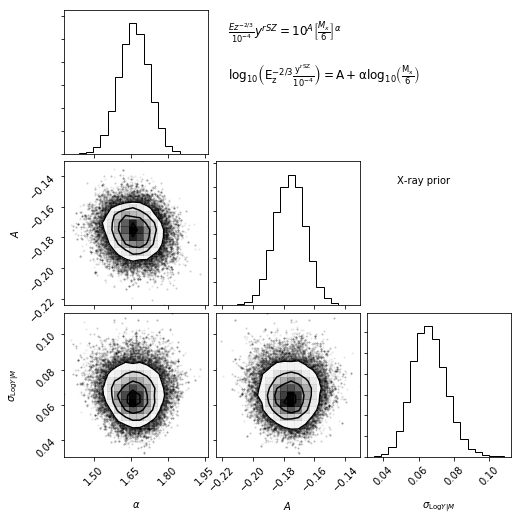

In [12]:
fig=corner.corner(samples, labels=[r"$\alpha$", "$A$", r"$\sigma_{{\rm Log}Y|M}$"])
fig.text(0.74,0.63,r"X-ray prior" )
#fig.text(0.73,0.6,r"$\alpha=$" + str(round(m_mcmc[0],3)) + "$\pm$" + str(round(np.mean(m_mcmc[1:]),3)))
#fig.text(0.73,0.57,r"$A=$" + str(round(b_mcmc[0],3)) + "$\pm$" + str(round(np.mean(b_mcmc[1:]),3)))
#fig.text(0.73,0.54,r"$\sigma_{{\rm Log}Y|M}=$" + str(round(f_mcmc[0],3)) + "$\pm$" + str(round(np.mean(f_mcmc[1:]),3)))
##fig.text(0.73,0.51,r"$ \rm{Corr}(\alpha,A)=$" + str(round(covmb/(errm*errb),3))) 
#fig.text(0.73,0.48,r"$ \rm{Corr}(\alpha,\sigma_{{\rm Log}Y|M})=$" + str(round(covmf/(errm*errf),3))) 
#fig.text(0.73,0.45,r"$ \rm{Corr}(A,\sigma_{{\rm Log}Y|M})=$" + str(round(covbf/(errb*errf),3))) 
fig.text(0.43,0.9,r"$\frac{Ez^{-2/3}}{10^{-4}} y^{rSZ} = 10^A \left[\frac{M_x}{6}\right]^{\alpha}$",fontsize=12) 
fig.text(0.43,0.82,r"$\rm{log}_{10}\left(E_z^{-2/3} \frac{y^{rSZ}}{10^{-4}}\right) = A + \alpha \rm{log}_{10}\left(\frac{M_x}{6}\right)$",fontsize=12) 
savefig(figpath + "test_xray_prior_y-m_mcmc.pdf",bbox_inches="tight")

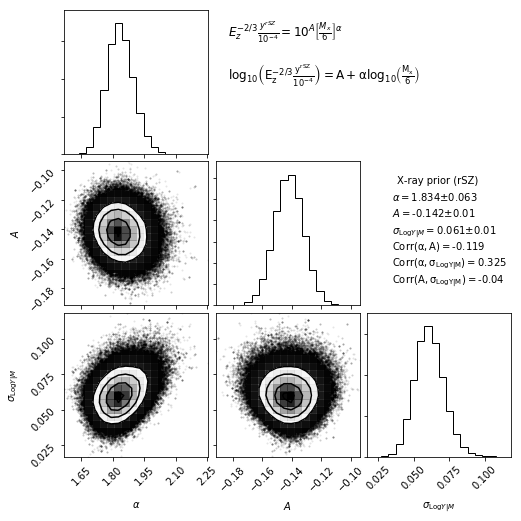

In [76]:
fig=corner.corner(samples, labels=[r"$\alpha$", "$A$", r"$\sigma_{{\rm Log}Y|M}$"])
fig.text(0.73,0.63,r"X-ray prior (rSZ)" )
fig.text(0.73,0.6,r"$\alpha=$" + str(round(m_mcmc[0],3)) + "$\pm$" + str(round(np.mean(m_mcmc[1:]),3)))
fig.text(0.73,0.57,r"$A=$" + str(round(b_mcmc[0],3)) + "$\pm$" + str(round(np.mean(b_mcmc[1:]),3)))
fig.text(0.73,0.54,r"$\sigma_{{\rm Log}Y|M}=$" + str(round(f_mcmc[0],3)) + "$\pm$" + str(round(np.mean(f_mcmc[1:]),3)))
fig.text(0.73,0.51,r"$ \rm{Corr}(\alpha,A)=$" + str(round(covmb/(errm*errb),3))) 
fig.text(0.73,0.48,r"$ \rm{Corr}(\alpha,\sigma_{{\rm Log}Y|M})=$" + str(round(covmf/(errm*errf),3))) 
fig.text(0.73,0.45,r"$ \rm{Corr}(A,\sigma_{{\rm Log}Y|M})=$" + str(round(covbf/(errb*errf),3))) 
fig.text(0.43,0.9,r"$E_z^{-2/3} \frac{y^{rSZ}}{10^{-4}} = 10^A \left[\frac{M_x}{6}\right]^{\alpha}$",fontsize=12) 
fig.text(0.43,0.82,r"$\rm{log}_{10}\left(E_z^{-2/3} \frac{y^{rSZ}}{10^{-4}}\right) = A + \alpha \rm{log}_{10}\left(\frac{M_x}{6}\right)$",fontsize=12) 
savefig("test_xray_prior_rsz_y-m_mcmc.pdf",bbox_inches="tight")

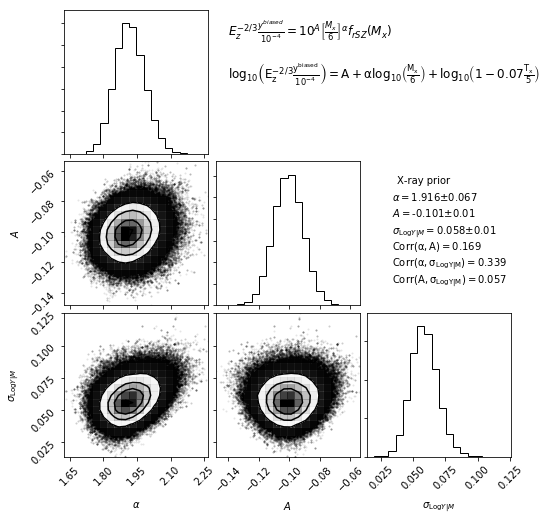

In [66]:
fig=corner.corner(samples, labels=[r"$\alpha$", "$A$", r"$\sigma_{{\rm Log}Y|M}$"])
fig.text(0.74,0.63,r"X-ray prior" )
fig.text(0.73,0.6,r"$\alpha=$" + str(round(m_mcmc[0],3)) + "$\pm$" + str(round(np.mean(m_mcmc[1:]),3)))
fig.text(0.73,0.57,r"$A=$" + str(round(b_mcmc[0],3)) + "$\pm$" + str(round(np.mean(b_mcmc[1:]),3)))
fig.text(0.73,0.54,r"$\sigma_{{\rm Log}Y|M}=$" + str(round(f_mcmc[0],3)) + "$\pm$" + str(round(np.mean(f_mcmc[1:]),3)))
fig.text(0.73,0.51,r"$ \rm{Corr}(\alpha,A)=$" + str(round(covmb/(errm*errb),3))) 
fig.text(0.73,0.48,r"$ \rm{Corr}(\alpha,\sigma_{{\rm Log}Y|M})=$" + str(round(covmf/(errm*errf),3))) 
fig.text(0.73,0.45,r"$ \rm{Corr}(A,\sigma_{{\rm Log}Y|M})=$" + str(round(covbf/(errb*errf),3))) 
fig.text(0.43,0.9,r"$E_z^{-2/3} \frac{y^{biased}}{10^{-4}} = 10^A \left[\frac{M_x}{6}\right]^{\alpha} f_{rSZ}(M_x)$",fontsize=12) 
fig.text(0.43,0.82,r"$\rm{log}_{10}\left(E_z^{-2/3} \frac{y^{biased}}{10^{-4}}\right) = A + \alpha \rm{log}_{10}\left(\frac{M_x}{6}\right)+ \rm{log}_{10}\left( 1 - 0.07 \frac{T_x}{5}\right)$",fontsize=12) 
savefig("test_xray_prior_y-m_mcmc.pdf",bbox_inches="tight")

In [148]:
mat=np.zeros((3,3),float)
mat[0,0]=errm**2.
mat[1,1]=errb**2.
mat[2,2]=errf**2.
mat[0,1]=covmb ; mat[1,0]=covmb
mat[0,2]=covmf ; mat[2,0]=covmf
mat[1,2]=covbf ; mat[2,1]=covbf

smat=np.identity(3)*np.diag(mat)

In [31]:
pos

[array([ 0.34690233, -0.08800053,  0.01553079]),
 array([-0.25891034,  0.03590872,  0.1074726 ]),
 array([-0.36791458, -0.04150998,  0.11469276]),
 array([ 0.66027329, -0.04994002, -0.14953585]),
 array([-0.07122983,  0.07558012, -0.08945371]),
 array([-0.33811349, -0.12763047, -0.0030847 ]),
 array([ 0.44004378,  0.143223  , -0.0853237 ]),
 array([ 0.03235407,  0.28183214,  0.03050227]),
 array([ 0.0862823 , -0.09958489, -0.19562906]),
 array([ 0.22742727,  0.13968741,  0.09888252]),
 array([-0.4717253 , -0.35554605,  0.01707888]),
 array([ 0.70463764, -0.29421599, -0.12289972]),
 array([ 0.18548936, -0.17854926, -0.06988006]),
 array([ 0.35685778,  0.06761706, -0.02916555]),
 array([-0.46879842,  0.13896308,  0.01272281]),
 array([ 0.98424781, -0.03729833, -0.14725288]),
 array([-0.14393013, -0.1648858 , -0.21918331]),
 array([-0.59485284, -0.01038703,  0.0252119 ]),
 array([-0.19510071, -0.07872153,  0.24417651]),
 array([-0.41574637, -0.02383717,  0.13274791]),
 array([ 0.24304769,

In [30]:
np.std(samples[:,0]-np.mean(samples[:,0]))

0.066160149143105945

In [151]:
print np.linalg.inv(mat)
print 
print np.linalg.inv(smat)

[[   284.92612469    161.2214513    -134.90462236]
 [   161.2214513   10402.84141714     86.69627834]
 [  -134.90462236     86.69627834   2834.59119819]]

[[   275.87692853      0.              0.        ]
 [     0.          10302.02375793      0.        ]
 [     0.              0.           2768.14003641]]


In [130]:
# np.linalg.inv(mat)
# sample=np.random.multivariate_normal(np.array([m_mcmc[0],b_mcmc[0],f_mcmc[0]]),mat,50000)
# ssample=np.random.multivariate_normal(np.array([m_mcmc[0],b_mcmc[0],f_mcmc[0]]),smat,50000)

# figure()
# hist(samples[:50000,0],bins=50,alpha=0.8)
# hist(ssample[:50000,0],bins=50,alpha=0.8)

# figure()
# scatter(sample[:,0],sample[:,1],c="r")
# scatter(ssample[:,0],ssample[:,1],c="b")
# scatter(samples[:50000,0],samples[:50000,1],c="g")